In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning

import xgboost as xgb
import keras

from ucimlrepo import fetch_ucirepo

from IPython.display import clear_output
import os
import logging
import re
import warnings

import utils

logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(asctime)s - %(message)s')

clear_output()

std_plot_size = (6.4, 4.8)
start_seed = 82

plots_dir = os.path.join('plots', 'part_b')
tables_dir = os.path.join('tables', 'part_b')

if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)
    
if not os.path.exists(tables_dir):
    os.makedirs(tables_dir)
    
sns.set_palette('hls')

minimal_run = False

rf_xgb_runs = 30 if not minimal_run else 2
reg_mlp_runs = 10 if not minimal_run else 2
dt_runs = 30 if not minimal_run else 2
mlp_runs = 30 if not minimal_run else 2

dt_depths = range(1, 21) if not minimal_run else [1, 2]
min_samples_gen = range(5, 805, 5) if not minimal_run else [790, 800]
rf_estimators = [10, 20, 40, 80, 160, 320, 640, 1280] if not minimal_run else [10, 20]
gradb_estimators = rf_estimators[:7] if not minimal_run else [10, 20]

dropouts = [0, 0.1, 0.2, 0.3, 0.4, 0.5] if not minimal_run else [0.1, 0.2]
decays = [0, 0.01, 0.001, 0.0001] if not minimal_run else [0.01, 0.001]

max_epochs = 1000 if not minimal_run else 3

logging.info('Start Execution')

INFO - 2024-11-14 22:00:28,236 - Start Execution


In [10]:
# Retrieve dataset
dataset = fetch_ucirepo(id=30)

# Merge target into dataframe for easy comparisons
df = pd.concat([dataset.data.features.copy(), dataset.data.targets.copy()], axis=1)

Switched Wife Working + Media Exposure to Make more sense
Adjusted contraceptive method param 

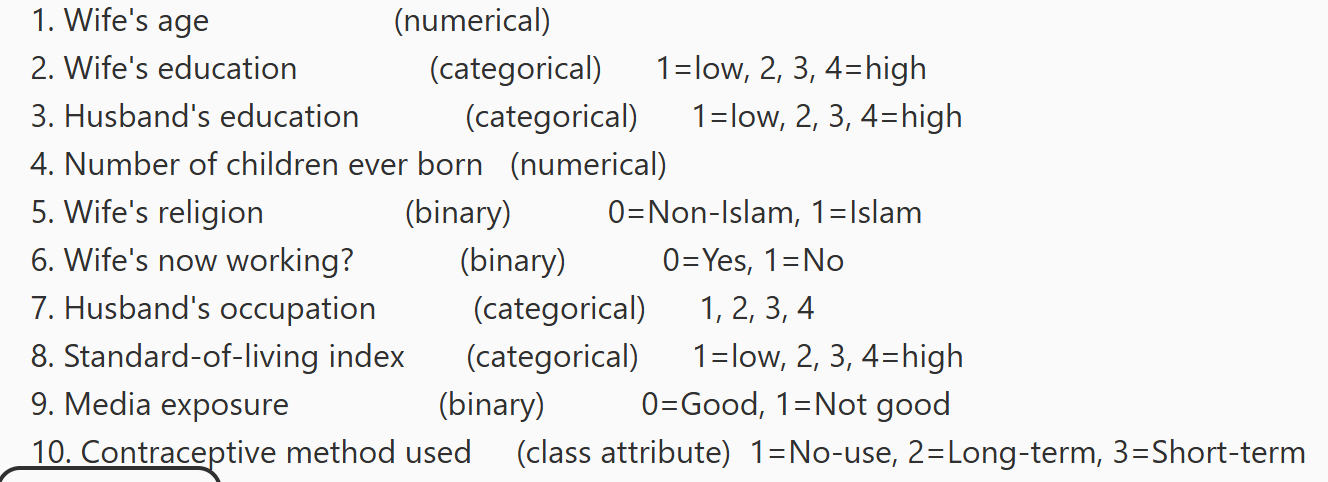

In [11]:
# Perform Cleaning
transformed_df = df.copy()

# TODO: consider changing ratios
transformed_df['adjusted_method'] = np.where(df['contraceptive_method'].eq(2), 5, df['contraceptive_method'])

# Reverse so that 1/true/positive are aligned
transformed_df['wife_working'] = df['wife_working'].eq(0).astype(int)
transformed_df['media_exposure'] = df['media_exposure'].eq(0).astype(int)

transformed_df = transformed_df.drop(columns='contraceptive_method')

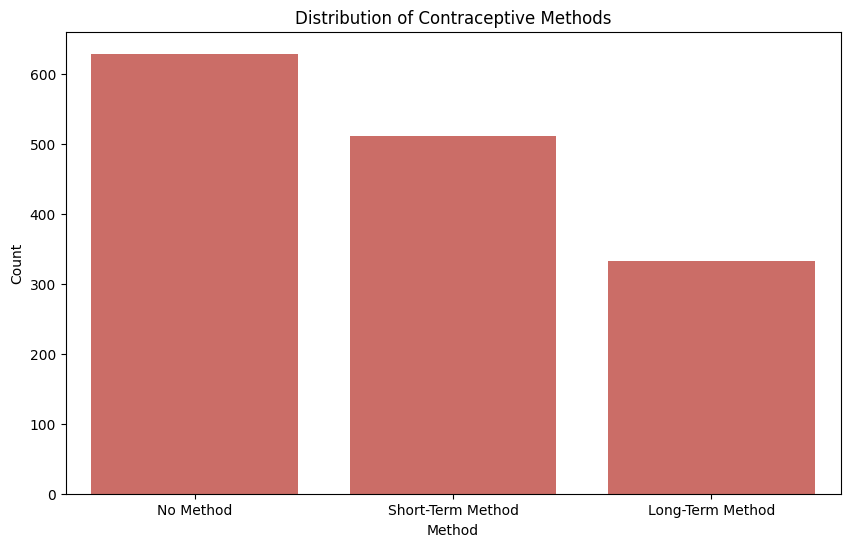

In [12]:
contra_methods = ['No Method', 'Short-Term Method', 'Long-Term Method']

method_labels = pd.DataFrame(np.select(
    [df['contraceptive_method'].eq(3), df['contraceptive_method'].eq(2)],
    contra_methods[1:],
    default=contra_methods[0]
), columns = ['Contraception Method'])

plt.figure(figsize=(10, 6))
sns.countplot(x='Contraception Method', data=method_labels, order=contra_methods)
plt.title('Distribution of Contraceptive Methods')
plt.xlabel('Method')
plt.ylabel('Count')
plt.savefig(os.path.join(plots_dir, 'class_distribution.png'))
plt.show()

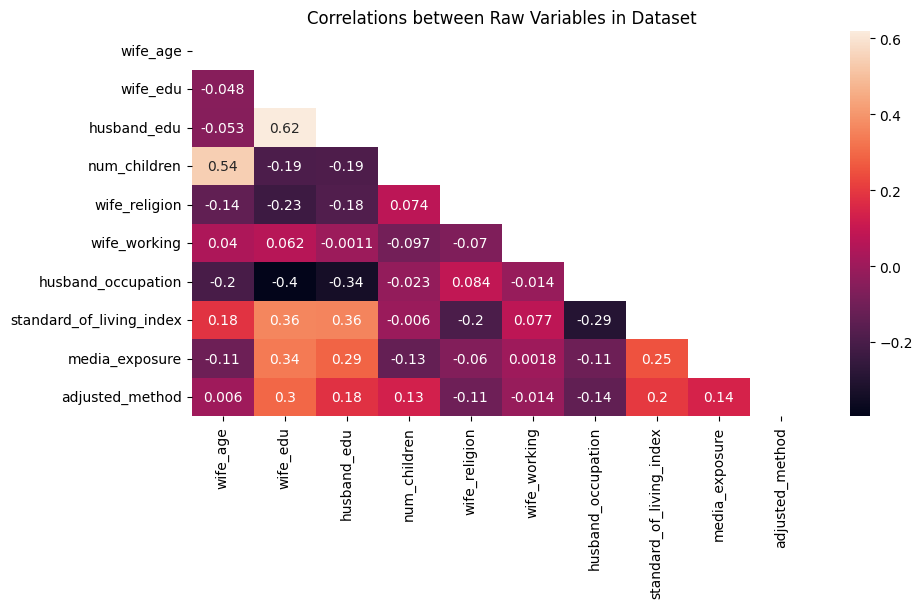

In [13]:
plt.figure(figsize=(10, 5))
plt.title('Correlations between Raw Variables in Dataset')

corr_df = transformed_df.corr()
# Create a mask of only the upper triangle, to simplify the heatmap
matrix = np.triu(corr_df)
sns.heatmap(corr_df, annot=True, mask=matrix)
plt.savefig(os.path.join(plots_dir, 'heat_map.png'), bbox_inches = 'tight')

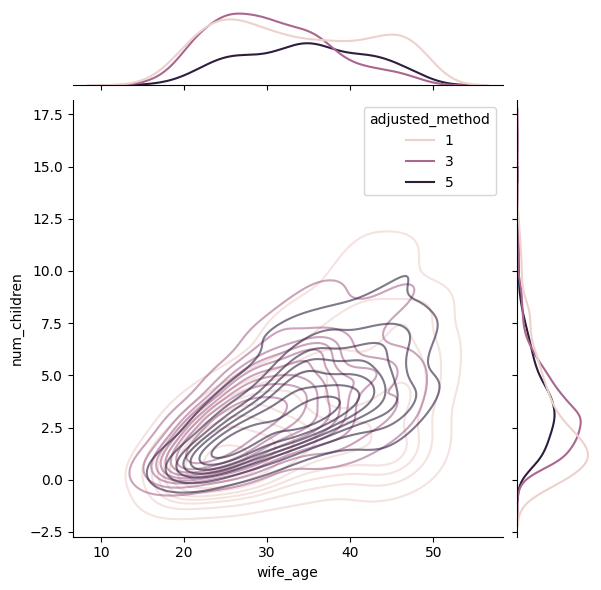

In [18]:
sns.jointplot(data=transformed_df, x="wife_age", y="num_children", hue="adjusted_method", kind="kde", alpha=0.6)
plt.savefig(os.path.join(plots_dir, 'num_child_vs_wife_age.png'))

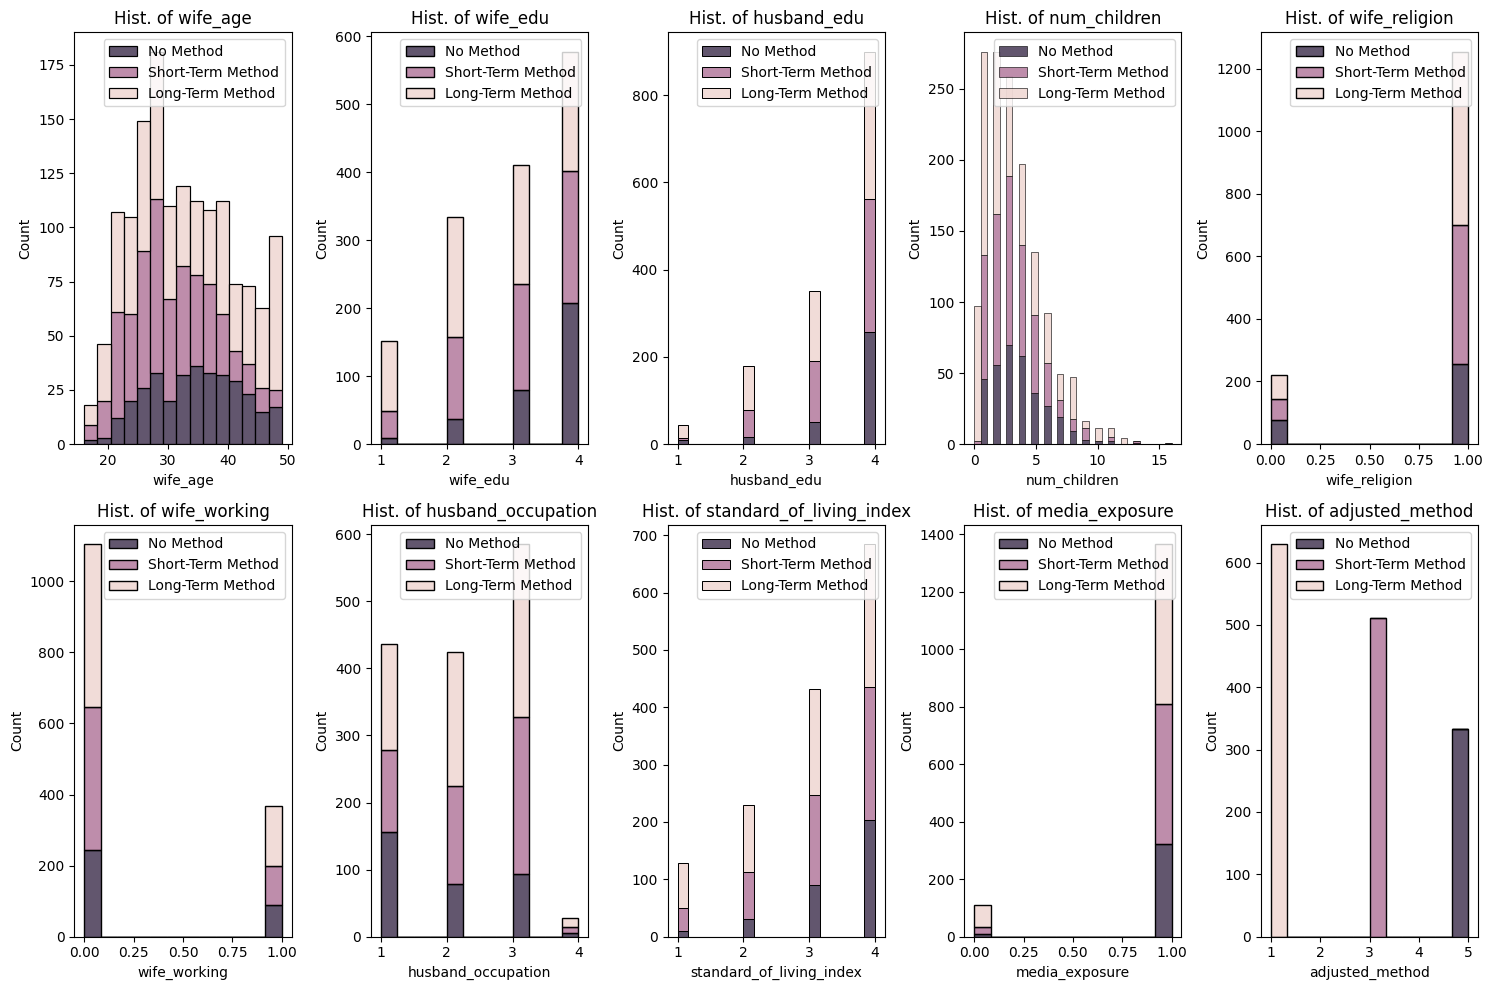

In [86]:
plt.figure(figsize=(15, 10))
for ii, feature in enumerate(transformed_df.columns, start=1):
    plt.subplot(2, 5, ii)
    sns.histplot(data=transformed_df, x=feature, hue='adjusted_method', multiple='stack')
    plt.title(f'Hist. of {feature}')
    plt.legend(title='', loc='upper right', labels=contra_methods)
    
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'feature_distributions.png'))
plt.show()

In [20]:
feature_df = transformed_df.drop(['adjusted_method'], axis=1)
target = transformed_df['adjusted_method']
model_accuracy = {}

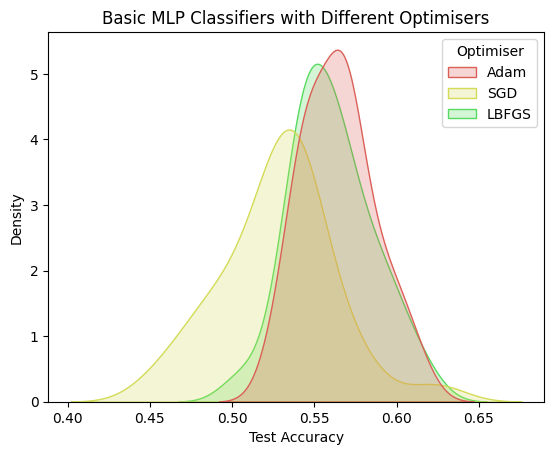

In [22]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    mlp_adam_df = utils.classifier_test(feature_df, target, MLPClassifier, {'solver': 'adam'},
                            [1000], 'max_iter', False, 'Max Iter', mlp_runs, True, start_seed
                            )

    mlp_adam_df['Optimiser'] = 'Adam'

    mlp_sgd_df = utils.classifier_test(feature_df, target, MLPClassifier, {'solver': 'sgd'},
                            [1000], 'max_iter', False, 'Max Iter', mlp_runs, True, start_seed
                            )
    mlp_sgd_df['Optimiser'] = 'SGD'
    
    mlp_lbfgs_df = utils.classifier_test(feature_df, target, MLPClassifier, {'solver': 'lbfgs'},
                            [1000], 'max_iter', False, 'Max Iter', mlp_runs, True, start_seed
                            )
    mlp_lbfgs_df['Optimiser'] = 'LBFGS'

sns.kdeplot(data=pd.concat([mlp_adam_df, mlp_sgd_df, mlp_lbfgs_df]), x='Test Accuracy', hue='Optimiser', fill=True)
plt.title('Basic MLP Classifiers with Different Optimisers')
plt.savefig(os.path.join(plots_dir, 'optimiser_comparison.png'))

model_accuracy['mlp_adam'] = float(mlp_adam_df['Test Accuracy'].mean().max().round(3))
model_accuracy['mlp_sgd'] = float(mlp_sgd_df['Test Accuracy'].mean().max().round(3))